# Teste supervisionado com dados tunados

In [1]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#ESCALONAMENTO DE DADOS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

#Evaluating
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#exibindo todas as colunas
pd.set_option('display.max_columns', None)

#definicao de funcoes que serao utilizadas
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

def score_evasao(y_true, y_pred): 
    tp = confusion_matrix(y_true, y_pred)[0, 0]
    fn = confusion_matrix(y_true, y_pred)[0, 1]
    
    return tp/(tp+fn)
   
#SELECIONANDO MELHOR MODEL RF
def make_RF(Xtrain, ytrain):
    #cria a randomforest 
    #forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 
    forest_clf = RandomForestClassifier(n_jobs=-1) 

    param_grid_forest = {'max_depth': [3, 5, None],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'n_estimators': [10, 30, 60, 100, 200],
                  'criterion': ["gini", "entropy"], 
                   #'class_weight': [{0:10, 1:.1}, 'balanced'] #foi utilizado quando os dados estavam desbalanceados
                    }

    
    #utilizando o score definido de acordo com a evasao
    #print(score_evasao(ytest, ypred_forest))
    #se = make_scorer(score_evasao)

    #seleciona o melhor modelo de acordo com os parâmetros
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, cv=10)    
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'f1')
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'roc_auc')
    grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'accuracy', cv=10)
    
    #kappa_scorer = make_scorer(cohen_kappa_score)
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = kappa_scorer, cv=10)
    
    grid_search_forest.fit(Xtrain, ytrain)
    print(grid_search_forest.best_params_)
    print(grid_search_forest.best_estimator_)
    
    #mostra os 5 melhores modelos
    report(grid_search_forest.cv_results_, 3)    
    
    return grid_search_forest.best_estimator_

def evaluating(model, ytest, ypred, Xtest):
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print("Cálculo de índices de avaliação:")
    
    print("Precisão: %f; Recall: %f, F1: %f" % (precision_score(ytest, ypred), 
                                                recall_score(ytest, ypred), 
                                                f1_score(ytest, ypred) ))

    #precisao
    print('Precisão CV:')
    scores = cross_val_score(model, Xtest, ytest, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print(roc_auc_score(ytest, y_scores))
    
def feature_ranking(Xtest, model):
    #exibe os atributos mais importantes
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], Xtest.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show()    
    
def evaluating_2(model, ytest, ypred, X, y, Xtest):
    #Evaluating
    plt.figure()
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))

    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))
    print(f1_score(ytest, ypred))

    #precisao
    print('Precisao')
    scores = cross_val_score(model, X, y, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    print(dados_clean.info())
    
    return (dados_clean, y)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')

dados_tunning.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Modelo 01: utilizando todos os dados

no cenário abaixo foram utilizados todos os dados incluindo as notas as quais os valores NAN foram preenchidas com -1, a fim de não serem limpados. 

o resultado como visto foi bastante instatisfatório, uma vez que o falto positivo (prever que não evadiu, mas o aluno evadiu) tem um valor muito elevado, sendo o pior erro no problema. É interessante notar que os índices de avaliação tradicionais (precision, recall, f1) foram bons, o que parece contraditório. A explicação se deve ao fato das classes estarem bastante desbalanceadas. Para a seleção do modelo foi utilizado o médodo kappa_scorer o que conseguiu trazer a tona o problema do erro elevado de falso positivo  

In [3]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

#convertendo os NaN das notas em -1 para usar o RF 
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

(8908, 31)
(8908, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908 entries, 0 to 998
Columns: 151 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(136)
memory usage: 2.1 MB
None


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


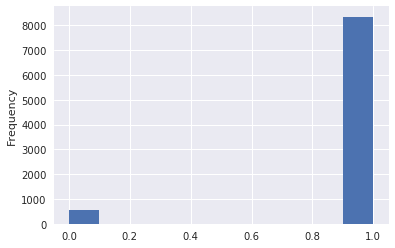

In [4]:
X, y = preparing_data(dados)
y.plot.hist()

In [15]:
X[['conceito_S', 'conceito_I', 'conceito_R', 'conceito_O']]
#X.head(3)

,conceito_S,conceito_I,conceito_R,conceito_O
0,0,0,0,0
1,0,0,1,0
10,0,0,0,0
1000,1,0,0,0
1001,0,0,1,0
1002,0,0,0,0
1003,0,0,0,0
1004,0,0,1,0
1005,0,0,0,0
1007,0,0,0,0


In [5]:
#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

In [6]:
#seleciona o melhor modelo
model_forest_completo = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_completo.predict(Xtest)

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.961 (std: 0.005)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.961 (std: 0.005)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.961 (std: 0.006)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}



Valor de falso positivo:0.6115107913669064
Cálculo de índices de avaliação:
Precisão: 0.960648; Recall: 0.993774, F1: 0.976930
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.96860987 0.97309417 0.95964126 0.93273543 0.95964126 0.97309417
 0.94618834 0.94170404 0.95045045 0.9638009 ]
0.9568959875607199


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


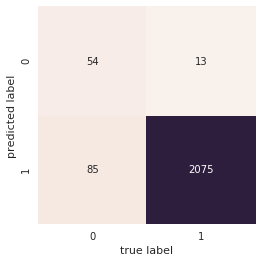

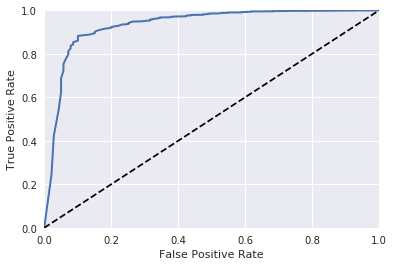

0.9321594448579067
Feature ranking:
1. feature 3 [MatemticaI120H] (0.095530)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.091087)
3. feature 17 [conceito_R] (0.061884)
4. feature 15 [conceito_I] (0.059942)
5. feature 5 [MatemticaI120H_freq] (0.048542)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.038120)
7. feature 9 [idade] (0.028960)
8. feature 20 [conceito_freq_R] (0.019766)
9. feature 13 [qtd_pessoas_domicilio] (0.019732)
10. feature 4 [MatemticaI120H_dependencia] (0.017832)
11. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.016805)
12. feature 33 [descricao_estado_civil_Divorciado(a)] (0.016589)
13. feature 12 [qnt_salarios] (0.016486)
14. feature 8 [artificial] (0.015465)
15. feature 14 [tempo_entre_conclusao_ingresso] (0.014852)
16. feature 126 [descricao_trabalho_Não informado] (0.013507)
17. feature 11 [qnt_pc] (0.013488)
18. feature 35 [descricao_estado_civil_Solteiro(a)] (0.012789)
19. feature 23 [descricao_area_residencial_Não informado] (0.012470)
20

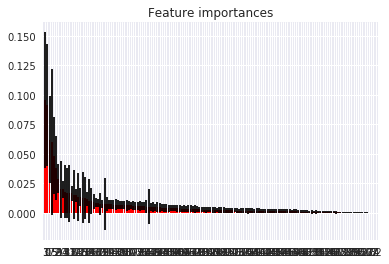

In [7]:
#avaliacao do modelo
evaluating(model_forest_completo, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_completo)

# Modelo 02: aumentando a quantidade de instâncias da classe de evasão

para tentar resolver o problema da classe desbalanceada será acrescentada novas instâncias a base da classe 0, a partir da duplicação de instâncias já contidas na base. Foram removidos as instâncias com dados gerados de forma artificial e as instâncias com notas NAN 

In [8]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

dados = dados[dados.artificial == 0]
dados.classe.value_counts()

1    7369
0     349
Name: classe, dtype: int64

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dados, dados.classe, random_state=0, stratify = dados.classe)

In [10]:
# separa as classes majoritária e minoritária 
df_majority = Xtrain[Xtrain.classe==1]
df_minority = Xtrain[Xtrain.classe==0]
 
# Upsample classe minoritária
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample com reposição
                                 n_samples=df_majority.shape[0],    # iguala a quantidade da classe majoritária
                                 random_state=0) 
 
# junta as duas classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print(df_upsampled.classe.value_counts())
#dados = 

1    5526
0    5526
Name: classe, dtype: int64


In [11]:
print(df_upsampled.shape)
print(Xtest.shape)

(11052, 31)
(1930, 31)


In [12]:
Xtrain, ytrain = preparing_data(df_upsampled)
Xtest2, ytest  = preparing_data(Xtest)

#ocorreu um problema que havia atributos q havia no treino, mas nao havia no teste devido a binarizacao dos elementos categoricos
#abaixo é consertado esse problema removendo os atributos que nao estao em comuns
print(Xtrain.shape)
print(Xtest2.shape)

res = np.setdiff1d(Xtrain.columns, Xtest2.columns)
for c in res:
    print(c)
    del Xtrain[c]

print(Xtrain.shape)
print(Xtest2.shape)    
    
#dividir os dados para treino e teste. default é 25% p teste
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(11052, 31)
(9585, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9585 entries, 5781 to 6589
Columns: 149 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(134)
memory usage: 2.3 MB
None
(1930, 31)
(1497, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 7727 to 5596
Columns: 145 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(130)
memory usage: 356.7 KB
None
(9585, 149)
(1497, 145)
descricao_area_residencial_Comunidade Quilombola
descricao_area_residencial_Não informado
descricao_imovel_Pensionato ou Alojamento
descricao_trabalho_Pescador
(9585, 145)
(1497, 145)


In [13]:
#seleciona o melhor modelo
model_forest_up = make_RF(Xtrain, ytrain)

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.996 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.996 (std: 0.002)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.996 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}



Valor de falso positivo:0.5529411764705883
Cálculo de índices de avaliação:
Precisão: 0.967653; Recall: 0.995751, F1: 0.981501
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.94701987 0.9602649  0.95333333 0.94666667 0.95333333 0.93959732
 0.94630872 0.96644295 0.94630872 0.93959732]
0.94988731351023


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


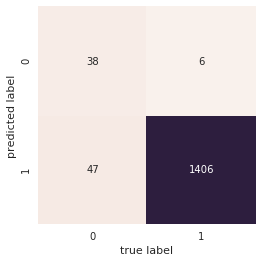

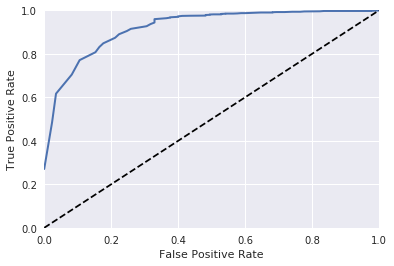

0.9203674387602067
Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.144952)
2. feature 3 [MatemticaI120H] (0.138899)
3. feature 17 [conceito_R] (0.088670)
4. feature 5 [MatemticaI120H_freq] (0.049123)
5. feature 15 [conceito_I] (0.048950)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.038263)
7. feature 9 [idade] (0.032389)
8. feature 16 [conceito_O] (0.018448)
9. feature 13 [qtd_pessoas_domicilio] (0.018197)
10. feature 12 [qnt_salarios] (0.016688)
11. feature 14 [tempo_entre_conclusao_ingresso] (0.014930)
12. feature 11 [qnt_pc] (0.013975)
13. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.013799)
14. feature 4 [MatemticaI120H_dependencia] (0.012513)
15. feature 19 [conceito_freq_R] (0.011947)
16. feature 6 [acompanhamento] (0.011510)
17. feature 10 [possui_necessidade_especial] (0.009531)
18. feature 7 [aluno_exclusivo_rede_publica] (0.008982)
19. feature 125 [pessoa_fisica__sexo_M] (0.007038)
20. feature 91 [descricao_raca_Branca] (0.006893)
21. f

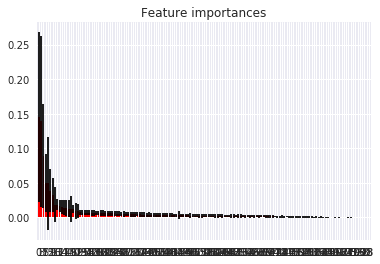

In [14]:
ypred_forest = model_forest_up.predict(Xtest2)

#avaliacao do modelo
evaluating(model_forest_up, ytest, ypred_forest, Xtest2)

feature_ranking(Xtest2, model_forest_up)

# Modelo 03: diminuindo a quantidade de instâncias da classe 01

In [15]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]] 

dados = dados[dados.artificial == 0]
print(dados.classe.value_counts())

# Separate majority and minority classes
df_majority = dados[dados.classe==1]
df_minority = dados[dados.classe==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority, df_majority_downsampled])
 
# Display new class counts
df_upsampled.classe.value_counts()
#dados = df_upsampled

1    7369
0     349
Name: classe, dtype: int64


1    349
0    349
Name: classe, dtype: int64

In [16]:
X, y = preparing_data(df_upsampled)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(698, 31)
(613, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 613 entries, 1028 to 31
Columns: 143 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(128)
memory usage: 144.9 KB
None


{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 60}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.885 (std: 0.042)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 60}

Model with rank: 1
Mean validation score: 0.885 (std: 0.044)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}

Model with rank: 1
Mean validation score: 0.885 (std: 0.033)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}

Valor de fa

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.88235294 0.875      0.8125     0.73333333 0.93333333 0.66666667
 0.86666667 0.66666667 0.93333333 0.93333333]
0.8303186274509804


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


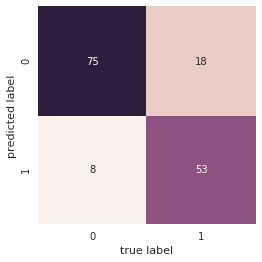

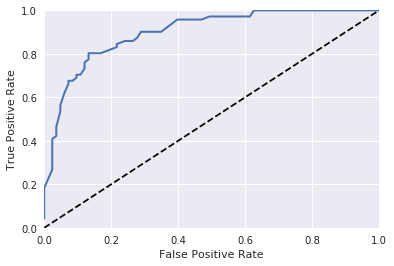

0.8988630578652639
Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.160144)
2. feature 3 [MatemticaI120H] (0.147770)
3. feature 17 [conceito_R] (0.084174)
4. feature 5 [MatemticaI120H_freq] (0.066294)
5. feature 15 [conceito_I] (0.056198)
6. feature 9 [idade] (0.029012)
7. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.025889)
8. feature 16 [conceito_O] (0.023223)
9. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.015424)
10. feature 13 [qtd_pessoas_domicilio] (0.015352)
11. feature 12 [qnt_salarios] (0.014944)
12. feature 4 [MatemticaI120H_dependencia] (0.014137)
13. feature 14 [tempo_entre_conclusao_ingresso] (0.013550)
14. feature 11 [qnt_pc] (0.013175)
15. feature 19 [conceito_freq_R] (0.011136)
16. feature 6 [acompanhamento] (0.010542)
17. feature 10 [possui_necessidade_especial] (0.010317)
18. feature 129 [sigla_CNAT] (0.009343)
19. feature 42 [descricao_historico_Técnico de Nível Médio em Eletrotécnica] (0.008474)
20. feature 7 [aluno_exclusivo_red

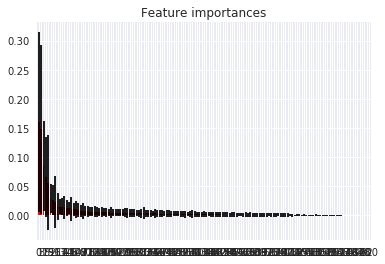

In [17]:
#seleciona o melhor modelo
model_forest_min = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_min.predict(Xtest)

#avaliacao do modelo
evaluating(model_forest_min, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_min)

# Selecionando atributos do melhor modelo

o melhor modelo verificado foi utilizando o downsample

In [19]:
from sklearn.feature_selection import RFECV

selector = RFECV(model_forest_min, cv=10, n_jobs=-1)
selector.fit(X, y)

atributos_01 = list(X.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(atributos_01))

Best Columns 
------------
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'descricao_companhia_domiciliar_Pais', 'descricao_raca_Branca', 'descricao_responsavel_escolaridade_Ensino médio incompleto', 'descricao_responsavel_escolaridade_Ensino superior incompleto', 'descricao_responsavel_financeiro_Mãe', 'descricao_trabalho_Nunca trabalhou', 'pessoa_fisica__sexo_M', 'sigla_CNAT', 'sigla_MC']



In [20]:
selector = RFECV(model_forest_min, cv=10, n_jobs=-1)
selector.fit(Xtest, ytest)

atributos_02 = list(Xtest.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(atributos_02))

Best Columns 
------------
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'conceito_freq_R', 'descricao_area_residencial_Rural', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Pais', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_historico_Técnico de Nivel Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Administração', 'descricao_historico_Técnico de Nível Médio em Edificações', 'descricao_historico_Técnico de Nível Médio em Eletrotécnica', 'descricao_h

# Modelo 04: modelo com seleção de atributos 

In [21]:
print(Xtest.columns.size)
print(len(atributos_01))
print(len(atributos_02))
print(np.setdiff1d(atributos_01, atributos_02))
print(np.setdiff1d(atributos_02, atributos_01))

143
25
91
[]
['aluno_exclusivo_rede_publica' 'conceito_freq_R'
 'descricao_area_residencial_Rural' 'descricao_area_residencial_Urbana'
 'descricao_companhia_domiciliar_Mãe'
 'descricao_companhia_domiciliar_Outros'
 'descricao_companhia_domiciliar_Pai'
 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)'
 'descricao_historico_Técnico de Nivel Médio em Informática'
 'descricao_historico_Técnico de Nível Médio em Administração'
 'descricao_historico_Técnico de Nível Médio em Edificações'
 'descricao_historico_Técnico de Nível Médio em Eletrotécnica'
 'descricao_historico_Técnico de Nível Médio em Eventos'
 'descricao_historico_Técnico de Nível Médio em Informática'
 'descricao_historico_Técnico de Nível Médio em Informática para Internet'
 'descricao_historico_Técnico de Nível Médio em Mecânica'
 'descricao_historico_Técnico de Nível Médio em Meio Ambiente'
 'descricao_historico_Técnico de Nível Médio em Recursos Pesqueiros'
 'descricao_historico_Técnico de Nível Médio em Têxtil'
 'de

In [22]:
Xtrain_red = Xtrain[atributos_02]
Xtest_red  = Xtest[atributos_02]

In [23]:
#seleciona o melhor modelo
model_forest_red = make_RF(Xtrain_red, ytrain)

ypred_forest = model_forest_red.predict(Xtest_red)


{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 30}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.889 (std: 0.043)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 30}

Model with rank: 1
Mean validation score: 0.889 (std: 0.034)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.885 (std: 0.044)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

Model with 

Valor de falso positivo:0.10843373493975904
Cálculo de índices de avaliação:
Precisão: 0.850000; Recall: 0.718310, F1: 0.778626
Precisão CV:


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.82352941 0.8125     0.8125     0.66666667 0.93333333 0.66666667
 0.86666667 0.73333333 0.93333333 0.93333333]
0.8181862745098039


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


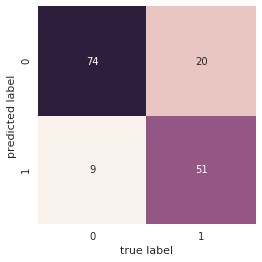

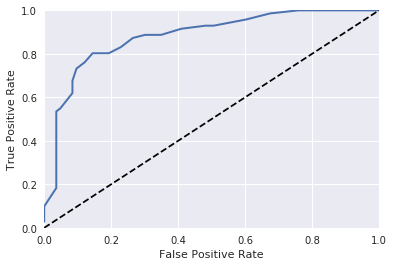

0.8809604615645681
Feature ranking:
1. feature 3 [MatemticaI120H] (0.163432)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.133953)
3. feature 16 [conceito_R] (0.084101)
4. feature 5 [MatemticaI120H_freq] (0.055378)
5. feature 14 [conceito_I] (0.047264)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.038461)
7. feature 15 [conceito_O] (0.032624)
8. feature 8 [idade] (0.025211)
9. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.023360)
10. feature 12 [qtd_pessoas_domicilio] (0.018908)
11. feature 4 [MatemticaI120H_dependencia] (0.017827)
12. feature 10 [qnt_pc] (0.014732)
13. feature 79 [sigla_CNAT] (0.014159)
14. feature 11 [qnt_salarios] (0.013001)
15. feature 6 [acompanhamento] (0.011970)
16. feature 13 [tempo_entre_conclusao_ingresso] (0.011890)
17. feature 17 [conceito_freq_R] (0.010537)
18. feature 19 [descricao_area_residencial_Urbana] (0.008273)
19. feature 43 [descricao_mae_escolaridade_Ensino médio completo] (0.008090)
20. feature 67 [descricao_responsavel_fi

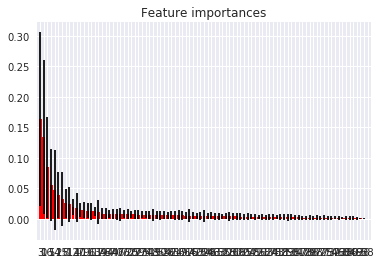

In [24]:
#avaliacao do modelo
evaluating(model_forest_red, ytest, ypred_forest, Xtest_red)

feature_ranking(Xtest_red, model_forest_red)

In [25]:
Xtrain_red = Xtrain[atributos_01]
Xtest_red  = Xtest[atributos_01]

{'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 60}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.900 (std: 0.041)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 60}

Model with rank: 2
Mean validation score: 0.895 (std: 0.040)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 30}

Model with rank: 2
Mean validation score: 0.895 (std: 0.033)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 30}

Model with

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.88235294 1.         0.75       0.73333333 1.         0.66666667
 0.8        0.73333333 0.86666667 0.86666667]
0.8299019607843137


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


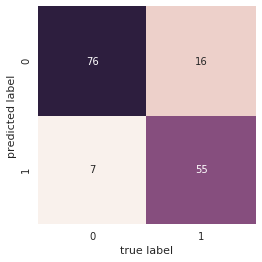

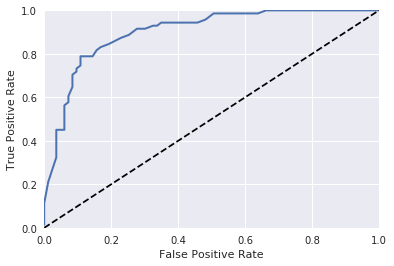

0.9008145257084677
Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.204579)
2. feature 3 [MatemticaI120H] (0.187057)
3. feature 15 [conceito_R] (0.103237)
4. feature 5 [MatemticaI120H_freq] (0.072268)
5. feature 13 [conceito_I] (0.052027)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.044763)
7. feature 7 [idade] (0.035031)
8. feature 11 [qtd_pessoas_domicilio] (0.028920)
9. feature 14 [conceito_O] (0.026256)
10. feature 9 [qnt_pc] (0.025308)
11. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.024395)
12. feature 10 [qnt_salarios] (0.023810)
13. feature 4 [MatemticaI120H_dependencia] (0.022926)
14. feature 12 [tempo_entre_conclusao_ingresso] (0.021947)
15. feature 23 [sigla_CNAT] (0.016861)
16. feature 22 [pessoa_fisica__sexo_M] (0.014774)
17. feature 8 [possui_necessidade_especial] (0.014046)
18. feature 20 [descricao_responsavel_financeiro_Mãe] (0.011786)
19. feature 16 [descricao_companhia_domiciliar_Pais] (0.010627)
20. feature 6 [acompanhamento] (

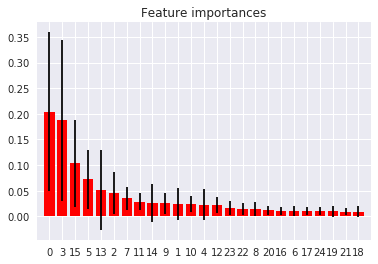

In [26]:
#seleciona o melhor modelo
model_forest_red = make_RF(Xtrain_red, ytrain)
ypred_forest = model_forest_red.predict(Xtest_red)

#avaliacao do modelo
evaluating(model_forest_red, ytest, ypred_forest, Xtest_red)

feature_ranking(Xtest_red, model_forest_red)

# Modelos sem atributos gerados após entradada no IF
Foram desconsiderado todos os atributos (nota, frequência, acompanhamento) que são gerados após a entrada no IF.

1    7369
0     349
Name: classe, dtype: int64
(7718, 22)
(7718, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7718 entries, 0 to 998
Columns: 137 entries, aluno_exclusivo_rede_publica to sigla_ZN
dtypes: bool(2), int64(6), uint8(129)
memory usage: 1.4 MB
None
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 30}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.955 (std: 0.001)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 30}

Model with rank: 1
Mean validation score: 0.955 (std: 0.001)
Para

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.95360825 0.95360825 0.95360825 0.95336788 0.95336788 0.95336788
 0.95336788 0.95833333 0.95833333 0.95833333]
0.9549296244858716


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


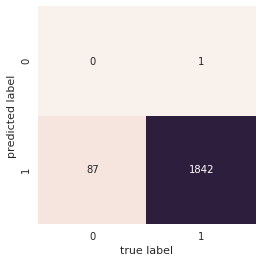

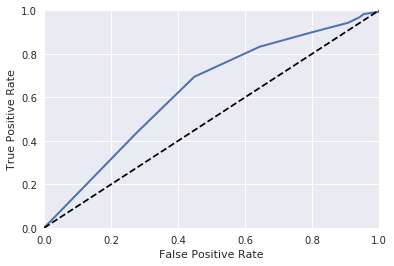

0.6315477638283408
Feature ranking:
1. feature 6 [qtd_pessoas_domicilio] (0.064293)
2. feature 2 [idade] (0.058603)
3. feature 5 [qnt_salarios] (0.039143)
4. feature 7 [tempo_entre_conclusao_ingresso] (0.037035)
5. feature 4 [qnt_pc] (0.030154)
6. feature 117 [pessoa_fisica__sexo_M] (0.027581)
7. feature 82 [descricao_raca_Branca] (0.021101)
8. feature 85 [descricao_raca_Parda] (0.020698)
9. feature 16 [descricao_companhia_domiciliar_Pais] (0.020551)
10. feature 99 [descricao_responsavel_financeiro_Mãe] (0.019866)
11. feature 61 [descricao_imovel_Próprio] (0.018434)
12. feature 110 [descricao_trabalho_Nunca trabalhou] (0.018312)
13. feature 103 [descricao_responsavel_financeiro_Pai] (0.016962)
14. feature 111 [descricao_trabalho_Não está trabalhando] (0.016438)
15. feature 73 [descricao_pai_escolaridade_Ensino fundamental incompleto] (0.015906)
16. feature 12 [descricao_companhia_domiciliar_Mãe] (0.015763)
17. feature 63 [descricao_mae_escolaridade_Ensino fundamental incompleto] (0.014

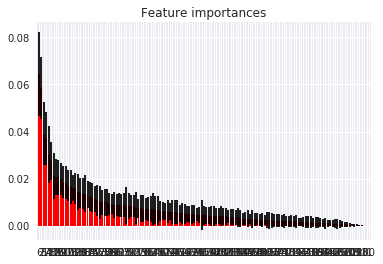

In [27]:
dados = dados_tunning.copy()

dados = dados[[
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 
       'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

dados = dados[dados.artificial == 0]
print(dados.classe.value_counts())

X, y = preparing_data(dados)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

#seleciona o melhor modelo
model_forest_completo = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_completo.predict(Xtest)

#avaliacao do modelo
evaluating(model_forest_completo, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_completo)

# Modelo utilizando downsample

1    7369
0     349
Name: classe, dtype: int64
(698, 22)
(698, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 698 entries, 1028 to 31
Columns: 132 entries, aluno_exclusivo_rede_publica to sigla_ZN
dtypes: bool(2), int64(6), uint8(124)
memory usage: 124.1 KB
None
{'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.616 (std: 0.050)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.614 (std

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.77777778 0.77777778 0.61111111 0.5        0.61111111 0.55555556
 0.66666667 0.52941176 0.6875     0.4375    ]
0.6154411764705883


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


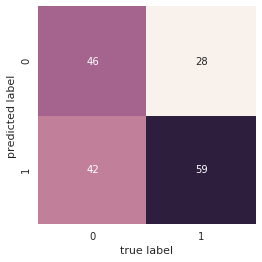

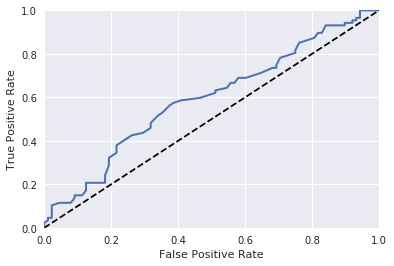

0.592149947753396
Feature ranking:
1. feature 2 [idade] (0.052850)
2. feature 6 [qtd_pessoas_domicilio] (0.052216)
3. feature 5 [qnt_salarios] (0.038573)
4. feature 4 [qnt_pc] (0.032511)
5. feature 7 [tempo_entre_conclusao_ingresso] (0.027185)
6. feature 112 [pessoa_fisica__sexo_M] (0.021132)
7. feature 57 [descricao_imovel_Próprio] (0.017526)
8. feature 22 [descricao_historico_Técnico de Nivel Médio em Informática] (0.016841)
9. feature 106 [descricao_trabalho_Nunca trabalhou] (0.016464)
10. feature 60 [descricao_mae_escolaridade_Ensino médio completo] (0.015968)
11. feature 78 [descricao_raca_Branca] (0.015838)
12. feature 95 [descricao_responsavel_financeiro_Mãe] (0.015628)
13. feature 14 [descricao_companhia_domiciliar_Pais] (0.015324)
14. feature 81 [descricao_raca_Parda] (0.015208)
15. feature 70 [descricao_pai_escolaridade_Ensino médio completo] (0.014395)
16. feature 84 [descricao_responsavel_escolaridade_Ensino fundamental incompleto] (0.014223)
17. feature 69 [descricao_pai_e

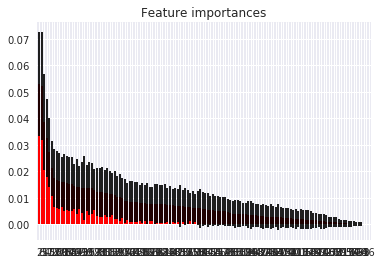

In [28]:
dados = dados_tunning.copy()

dados = dados[[
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 
       'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

dados = dados[dados.artificial == 0]
print(dados.classe.value_counts())

# Separate majority and minority classes
df_majority = dados[dados.classe==1]
df_minority = dados[dados.classe==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
 
# Display new class counts
df_downsampled.classe.value_counts()

X, y = preparing_data(df_downsampled)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

#seleciona o melhor modelo
model_forest_down = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_down.predict(Xtest)

#avaliacao do modelo
evaluating(model_forest_down, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_down)

# Selecionando atributos

In [29]:
selector = RFECV(model_forest_down, cv=10, n_jobs=-1)
selector.fit(X, y)

best_columns = list(X.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))

Best Columns 
------------
['idade', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'descricao_companhia_domiciliar_Pais', 'descricao_imovel_Próprio', 'descricao_pai_escolaridade_Ensino fundamental incompleto', 'descricao_raca_Parda', 'descricao_responsavel_financeiro_Mãe', 'descricao_trabalho_Nunca trabalhou', 'pessoa_fisica__sexo_M']



In [30]:
selector = RFECV(model_forest_down, cv=10, n_jobs=-1)
selector.fit(Xtest, ytest)

atributos = list(Xtest.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(atributos))

Best Columns 
------------
['aluno_exclusivo_rede_publica', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'descricao_area_residencial_Rural', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Outros', 'descricao_companhia_domiciliar_Pai', 'descricao_companhia_domiciliar_Pais', 'descricao_companhia_domiciliar_Parente(s) ou amigo(s)', 'descricao_estado_civil_Solteiro(a)', 'descricao_historico_Técnico de Nivel Médio em Agropecuária, na Forma Integrada', 'descricao_historico_Técnico de Nivel Médio em Equipamentos Biomédicos', 'descricao_historico_Técnico de Nivel Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Administração', 'descricao_historico_Técnico de Nível Médio em Alimentos', 'descricao_historico_Técnico de Nível Médio em Apicultura', 'descricao_historico_Técnico de Nível Médio em Controle Ambiental', 'descricao_historico_Técn

# Modelo com seleção de atributos

In [ ]:
#atributos = ['idade', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso']

In [33]:
Xtrain_red = Xtrain[best_columns]
Xtest_red  = Xtest[best_columns]

{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.591 (std: 0.042)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.589 (std: 0.046)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.589 (std: 0.046)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10}

Valor de fals

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.61111111 0.83333333 0.55555556 0.61111111 0.66666667 0.55555556
 0.55555556 0.58823529 0.6875     0.375     ]
0.6039624183006536


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


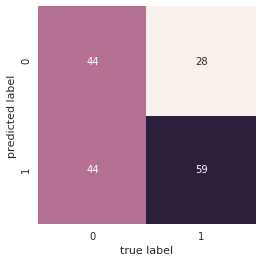

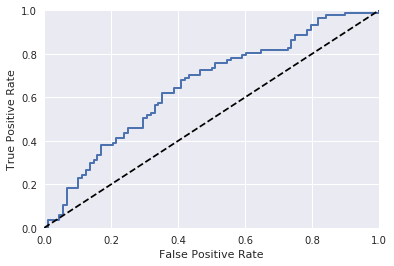

0.6509926854754442
Feature ranking:
1. feature 0 [idade] (0.285207)
2. feature 3 [qtd_pessoas_domicilio] (0.175697)
3. feature 1 [qnt_pc] (0.174481)
4. feature 2 [qnt_salarios] (0.106842)
5. feature 4 [tempo_entre_conclusao_ingresso] (0.082871)
6. feature 10 [descricao_trabalho_Nunca trabalhou] (0.032041)
7. feature 8 [descricao_raca_Parda] (0.029678)
8. feature 7 [descricao_pai_escolaridade_Ensino fundamental incompleto] (0.028166)
9. feature 6 [descricao_imovel_Próprio] (0.025945)
10. feature 11 [pessoa_fisica__sexo_M] (0.025684)
11. feature 9 [descricao_responsavel_financeiro_Mãe] (0.022612)
12. feature 5 [descricao_companhia_domiciliar_Pais] (0.010776)


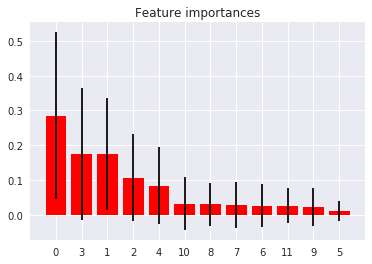

In [34]:
#seleciona o melhor modelo
model_forest_red = make_RF(Xtrain_red, ytrain)
ypred_forest = model_forest_red.predict(Xtest_red)

#avaliacao do modelo
evaluating(model_forest_red, ytest, ypred_forest, Xtest_red)

feature_ranking(Xtest_red, model_forest_red)

In [ ]:
#FIM